# Modelo Predictivo para el Desempleo en Honduras

Este notebook desarrolla un modelo predictivo y análisis de regresión para el **Desempleo** utilizando datos socioeconómicos de Honduras.


## 1. Import Required Libraries

Importamos las librerías necesarias para el análisis de datos y machine learning.

In [2]:
# Librerías para manejo de datos
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Librerías para machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 2. Load and Explore Unemployment Data

Cargamos los datasets relacionados con desempleo y otros indicadores socioeconómicos.

In [3]:
# Cargar datasets específicos para el modelo predictivo de desempleo
unemployment_total_df = pd.read_csv('../Datasets/Unemployment_total.csv', skiprows=4)
unemployment_female_df = pd.read_csv('../Datasets/Unemployment_Female.csv', skiprows=4)
unemployment_male_df = pd.read_csv('../Datasets/Unemployment_Male.csv', skiprows=4)
unemployment_basic_edu_df = pd.read_csv('../Datasets/Unemployment_BasicEducation.csv', skiprows=4)
unemployment_advanced_edu_df = pd.read_csv('../Datasets/Unemployment_AdvancedEducation.csv', skiprows=4)

print("Datasets de desempleo cargados:")
print(f"   • Desempleo Total: {unemployment_total_df.shape}")
print(f"   • Desempleo Femenino: {unemployment_female_df.shape}")
print(f"   • Desempleo Masculino: {unemployment_male_df.shape}")
print(f"   • Desempleo Educación Básica: {unemployment_basic_edu_df.shape}")
print(f"   • Desempleo Educación Avanzada: {unemployment_advanced_edu_df.shape}")

Datasets de desempleo cargados:
   • Desempleo Total: (266, 70)
   • Desempleo Femenino: (266, 70)
   • Desempleo Masculino: (266, 70)
   • Desempleo Educación Básica: (266, 70)
   • Desempleo Educación Avanzada: (266, 70)


## 3. Data Preprocessing and Cleaning

Limpiamos y preparamos los datos para el análisis y modelado.

In [4]:
def clean_dataset(df, dataset_name):
    """
    Función para limpiar datasets de manera consistente
    """
    print(f"\nLimpiando dataset: {dataset_name}")
    print(f"Dimensiones originales: {df.shape}")
    
    # Copia del dataset
    df_clean = df.copy()
    
    # Limpiar nombres de columnas
    df_clean.columns = df_clean.columns.str.strip().str.replace("\ufeff", "")
    
    # Filtrar solo Honduras si existe columna de país
    if 'Country Name' in df_clean.columns:
        honduras_mask = df_clean['Country Name'].str.contains('Honduras', case=False, na=False)
        df_clean = df_clean[honduras_mask]
        print(f"Datos filtrados para Honduras: {df_clean.shape}")
    
    # Identificar columnas de años (formato numérico)
    year_columns = [col for col in df_clean.columns if str(col).isdigit() and len(str(col)) == 4]
    
    if year_columns:
        # Filtrar años
        years_2010_2022 = [col for col in year_columns if 2010 <= int(col) <= 2022]
        
        # Seleccionar columnas relevantes
        keep_columns = [col for col in df_clean.columns if not str(col).isdigit() or str(col) in years_2010_2022]
        df_clean = df_clean[keep_columns]
        
        print(f"Años incluidos: {sorted([int(col) for col in years_2010_2022])}")
    
    print(f"Dimensiones finales: {df_clean.shape}")
    return df_clean

# Limpiar datasets de desempleo
unemployment_total_clean = clean_dataset(unemployment_total_df, "Desempleo Total")
unemployment_female_clean = clean_dataset(unemployment_female_df, "Desempleo Femenino")
unemployment_male_clean = clean_dataset(unemployment_male_df, "Desempleo Masculino")
unemployment_basic_edu_clean = clean_dataset(unemployment_basic_edu_df, "Desempleo Educación Básica")
unemployment_advanced_edu_clean = clean_dataset(unemployment_advanced_edu_df, "Desempleo Educación Avanzada")


Limpiando dataset: Desempleo Total
Dimensiones originales: (266, 70)
Datos filtrados para Honduras: (1, 70)
Años incluidos: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Dimensiones finales: (1, 18)

Limpiando dataset: Desempleo Femenino
Dimensiones originales: (266, 70)
Datos filtrados para Honduras: (1, 70)
Años incluidos: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Dimensiones finales: (1, 18)

Limpiando dataset: Desempleo Masculino
Dimensiones originales: (266, 70)
Datos filtrados para Honduras: (1, 70)
Años incluidos: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Dimensiones finales: (1, 18)

Limpiando dataset: Desempleo Educación Básica
Dimensiones originales: (266, 70)
Datos filtrados para Honduras: (1, 70)
Años incluidos: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Dimensiones finales: (1, 18)

Limpiando dataset: Desempleo Educación Avanzada
D

In [5]:
def reshape_to_long_format(df, dataset_name, value_column_name):
    """
    Convierte el dataset del formato wide a long format
    """
    print(f"\nConvirtiendo {dataset_name} a formato largo...")
    
    # Identificar columnas de años
    year_columns = [col for col in df.columns if str(col).isdigit() and len(str(col)) == 4]
    
    if not year_columns:
        print(f"No se encontraron columnas de años en {dataset_name}")
        return None
    
    # Columnas que no son años
    id_columns = [col for col in df.columns if col not in year_columns]
    
    # Reshape a formato largo
    df_long = pd.melt(df, 
                      id_vars=id_columns, 
                      value_vars=year_columns,
                      var_name='Year', 
                      value_name=value_column_name)
    
    # Convertir Year a int
    df_long['Year'] = df_long['Year'].astype(int)
    
    # Limpiar valores nulos
    df_long = df_long.dropna(subset=[value_column_name])
    
    print(f"Dimensiones del dataset en formato largo: {df_long.shape}")
    return df_long

# Convertir datasets a formato largo
unemployment_total_long = reshape_to_long_format(unemployment_total_clean, "Desempleo Total", "Unemployment_Total")
unemployment_female_long = reshape_to_long_format(unemployment_female_clean, "Desempleo Femenino", "Unemployment_Female")
unemployment_male_long = reshape_to_long_format(unemployment_male_clean, "Desempleo Masculino", "Unemployment_Male")
unemployment_basic_edu_long = reshape_to_long_format(unemployment_basic_edu_clean, "Desempleo Educación Básica", "Unemployment_Basic_Education")
unemployment_advanced_edu_long = reshape_to_long_format(unemployment_advanced_edu_clean, "Desempleo Educación Avanzada", "Unemployment_Advanced_Education")



Convirtiendo Desempleo Total a formato largo...
Dimensiones del dataset en formato largo: (13, 7)

Convirtiendo Desempleo Femenino a formato largo...
Dimensiones del dataset en formato largo: (13, 7)

Convirtiendo Desempleo Masculino a formato largo...
Dimensiones del dataset en formato largo: (13, 7)

Convirtiendo Desempleo Educación Básica a formato largo...
Dimensiones del dataset en formato largo: (12, 7)

Convirtiendo Desempleo Educación Avanzada a formato largo...
Dimensiones del dataset en formato largo: (12, 7)


## 4. Feature Selection and Engineering

Seleccionamos y creamos variables relevantes para el modelo predictivo.

In [6]:
# Crear dataset combinado para el modelado
def create_combined_unemployment_dataset():
    """
    Combina los datasets de desempleo en uno solo para el modelado
    """
    
    # Verificar que tengamos al menos el dataset principal
    if unemployment_total_long is None or unemployment_total_long.empty:
        print("No hay datos de desempleo total disponibles")
        return None
    
    # Iniciar con el dataset principal de desempleo total
    combined_df = unemployment_total_long[['Year', 'Unemployment_Total']].copy()
    
    # Combinar con desempleo femenino
    if unemployment_female_long is not None and not unemployment_female_long.empty:
        try:
            female_data = unemployment_female_long[['Year', 'Unemployment_Female']].copy()
            combined_df = pd.merge(combined_df, female_data, on='Year', how='left')
        except Exception as e:
            print(f"No se pudo combinar desempleo femenino: {e}")
    
    # Combinar con desempleo masculino
    if unemployment_male_long is not None and not unemployment_male_long.empty:
        try:
            male_data = unemployment_male_long[['Year', 'Unemployment_Male']].copy()
            combined_df = pd.merge(combined_df, male_data, on='Year', how='left')
        except Exception as e:
            print(f"No se pudo combinar desempleo masculino: {e}")
    
    # Combinar con desempleo educación básica
    if unemployment_basic_edu_long is not None and not unemployment_basic_edu_long.empty:
        try:
            basic_edu_data = unemployment_basic_edu_long[['Year', 'Unemployment_Basic_Education']].copy()
            combined_df = pd.merge(combined_df, basic_edu_data, on='Year', how='left')
        except Exception as e:
            print(f"No se pudo combinar desempleo educación básica: {e}")
    
    # Combinar con desempleo educación avanzada
    if unemployment_advanced_edu_long is not None and not unemployment_advanced_edu_long.empty:
        try:
            advanced_edu_data = unemployment_advanced_edu_long[['Year', 'Unemployment_Advanced_Education']].copy()
            combined_df = pd.merge(combined_df, advanced_edu_data, on='Year', how='left')
        except Exception as e:
            print(f"No se pudo combinar desempleo educación avanzada: {e}")
    
    # Eliminar filas con valores nulos en la variable objetivo principal
    combined_df = combined_df.dropna(subset=['Unemployment_Total'])
    
    return combined_df

# Crear dataset combinado
model_data = create_combined_unemployment_dataset()

if model_data is not None:
    print(f"\nDataset combinado creado con {model_data.shape[0]} observaciones y {model_data.shape[1]} variables")
    print("\nPrimeras 5 filas:")
    display(model_data.head())
    
    print(f"\nColumnas disponibles: {list(model_data.columns)}")
else:
    print("No se pudo crear el dataset combinado")


Dataset combinado creado con 13 observaciones y 6 variables

Primeras 5 filas:


,Year,Unemployment_Total,Unemployment_Female,Unemployment_Male,Unemployment_Basic_Education,Unemployment_Advanced_Education
0,2010,4.119,5.462,3.413,3.849,5.795
1,2011,4.474,6.413,3.510,4.233,5.886
2,2012,3.755,5.195,3.053,3.711,3.644
3,2013,5.646,7.563,4.630,5.536,6.695
4,2014,7.078,9.408,5.776,7.348,8.720



Columnas disponibles: ['Year', 'Unemployment_Total', 'Unemployment_Female', 'Unemployment_Male', 'Unemployment_Basic_Education', 'Unemployment_Advanced_Education']


🔧 Creando variables adicionales (Feature Engineering)...
📁 Guardando datos originales como respaldo...
   ✅ Year_normalized creada
   ✅ Year_squared creada
   ✅ Time_trend creada
   ✅ Unemployment_Total_lag1 creada
   ✅ Unemployment_Female_lag1 creada
   ✅ Unemployment_Male_lag1 creada
   ✅ Unemployment_Basic_Education_lag1 creada
   ✅ Unemployment_Advanced_Education_lag1 creada
   ✅ Unemployment_Total_change creada
   ✅ Unemployment_Female_change creada
   ✅ Unemployment_Male_change creada
   ✅ Unemployment_Basic_Education_change creada
   ✅ Unemployment_Advanced_Education_change creada
   ✅ Gender_Gap creada
   ✅ Gender_Ratio creada
   ✅ Gender_Average creada
   ✅ Education_Gap creada
   ✅ Education_Ratio creada
   ✅ Education_Average creada
   ✅ Period creada

✅ Feature Engineering completado.
📊 Tamaño final: (10, 26)
📈 Total de columnas: 26
🆕 Variables engineered: 20 columnas
   ['Year_normalized', 'Year_squared', 'Time_trend', 'Unemployment_Total_lag1', 'Unemployment_Female_lag1',

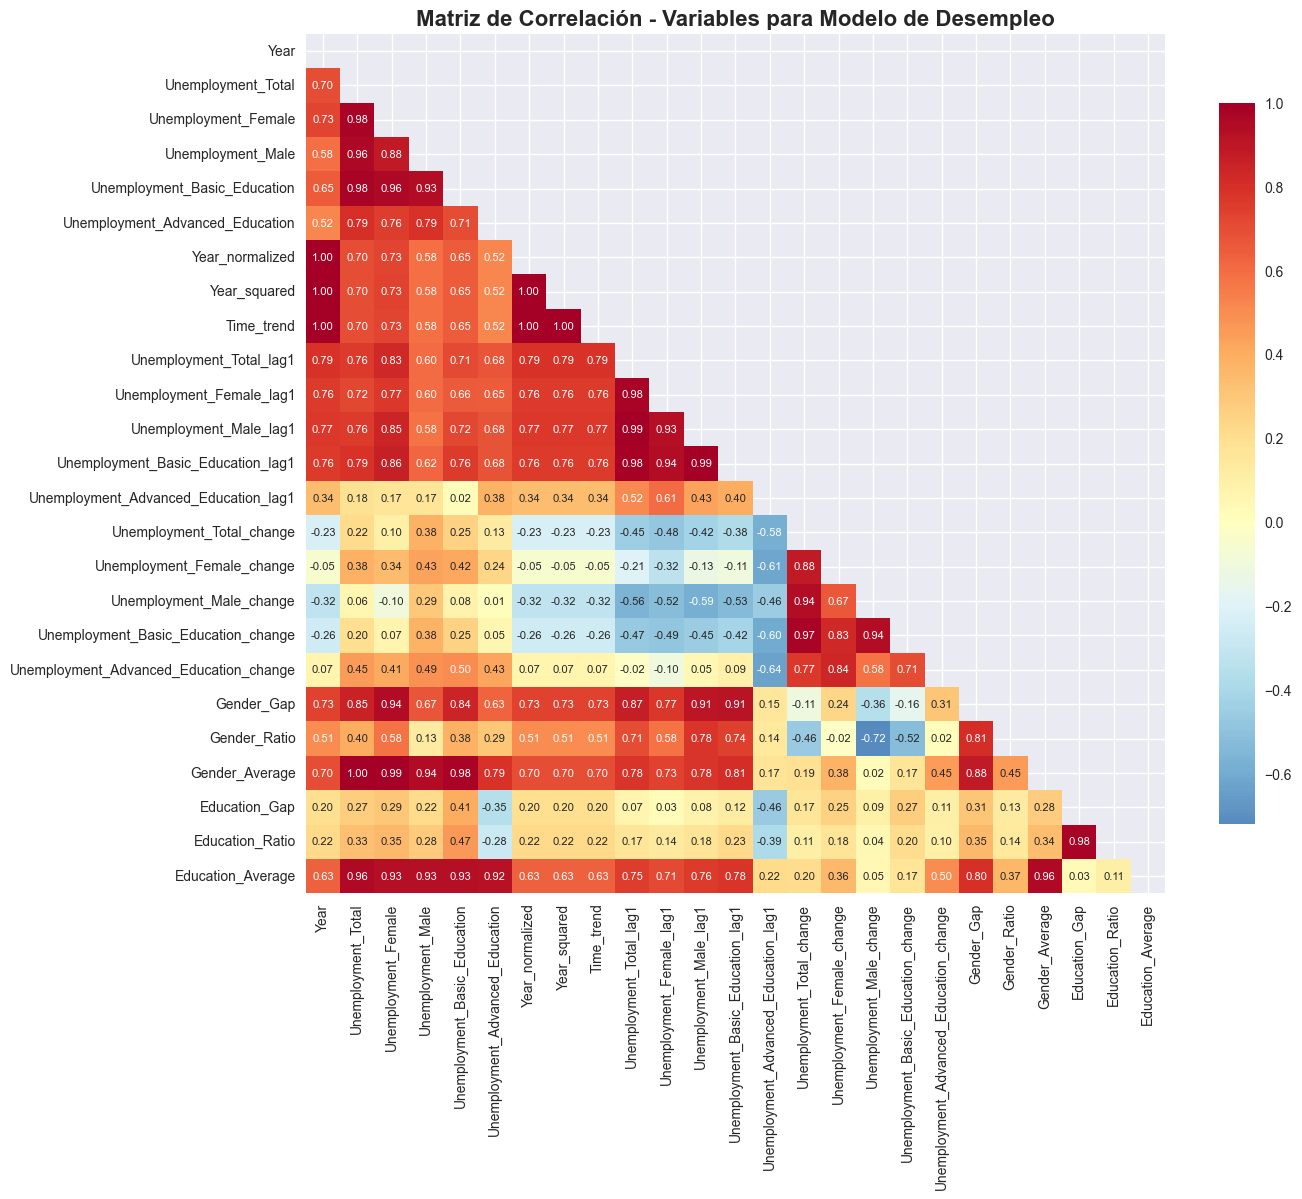


🎯 CORRELACIONES MÁS FUERTES CON DESEMPLEO TOTAL:
   📈 Gender_Average: 0.998
   📈 Unemployment_Female: 0.978
   📈 Unemployment_Basic_Education: 0.978
   📈 Unemployment_Male: 0.960
   📈 Education_Average: 0.959
   📈 Gender_Gap: 0.853
   📈 Unemployment_Advanced_Education: 0.793
   📈 Unemployment_Basic_Education_lag1: 0.788
   📈 Unemployment_Total_lag1: 0.761


In [7]:
# Feature Engineering - Crear variables adicionales
if model_data is not None and len(model_data) > 0:
    print("🔧 Creando variables adicionales (Feature Engineering)...")
    
    # Hacer una copia limpia para evitar duplicaciones
    if 'model_data_original' not in locals():
        model_data_original = model_data.copy()
        print("📁 Guardando datos originales como respaldo...")
    else:
        model_data = model_data_original.copy()
        print("🔄 Reiniciando desde datos originales...")
    
    # Crear variables temporales (solo si no existen)
    if 'Year_normalized' not in model_data.columns:
        model_data['Year_normalized'] = (model_data['Year'] - model_data['Year'].min()) / (model_data['Year'].max() - model_data['Year'].min())
        print("   ✅ Year_normalized creada")
    
    if 'Year_squared' not in model_data.columns:
        model_data['Year_squared'] = model_data['Year'] ** 2
        print("   ✅ Year_squared creada")
    
    if 'Time_trend' not in model_data.columns:
        model_data['Time_trend'] = range(len(model_data))
        print("   ✅ Time_trend creada")
    
    # Variables de lag (valores del año anterior) si hay suficientes datos
    if len(model_data) > 1:
        model_data = model_data.sort_values('Year')
        
        # Variables de lag solo si no existen
        if 'Unemployment_Total_lag1' not in model_data.columns:
            model_data['Unemployment_Total_lag1'] = model_data['Unemployment_Total'].shift(1)
            print("   ✅ Unemployment_Total_lag1 creada")
        
        # Si hay datos de género, crear variables de lag también
        if 'Unemployment_Female' in model_data.columns and 'Unemployment_Female_lag1' not in model_data.columns:
            model_data['Unemployment_Female_lag1'] = model_data['Unemployment_Female'].shift(1)
            print("   ✅ Unemployment_Female_lag1 creada")
        
        if 'Unemployment_Male' in model_data.columns and 'Unemployment_Male_lag1' not in model_data.columns:
            model_data['Unemployment_Male_lag1'] = model_data['Unemployment_Male'].shift(1)
            print("   ✅ Unemployment_Male_lag1 creada")
        
        # Si hay datos de educación, crear variables de lag
        if 'Unemployment_Basic_Education' in model_data.columns and 'Unemployment_Basic_Education_lag1' not in model_data.columns:
            model_data['Unemployment_Basic_Education_lag1'] = model_data['Unemployment_Basic_Education'].shift(1)
            print("   ✅ Unemployment_Basic_Education_lag1 creada")
        
        if 'Unemployment_Advanced_Education' in model_data.columns and 'Unemployment_Advanced_Education_lag1' not in model_data.columns:
            model_data['Unemployment_Advanced_Education_lag1'] = model_data['Unemployment_Advanced_Education'].shift(1)
            print("   ✅ Unemployment_Advanced_Education_lag1 creada")
        
        # Crear variables de cambio porcentual (solo si no existen)
        for col in model_data.select_dtypes(include=[np.number]).columns:
            change_col = f'{col}_change'
            if (col not in ['Year', 'Year_normalized', 'Year_squared', 'Time_trend'] 
                and not col.endswith('_lag1') 
                and not col.endswith('_change')
                and change_col not in model_data.columns):
                model_data[change_col] = model_data[col].pct_change()
                print(f"   ✅ {change_col} creada")
    
    # Variables de interacción entre género (solo si no existen)
    if ('Unemployment_Female' in model_data.columns and 'Unemployment_Male' in model_data.columns):
        if 'Gender_Gap' not in model_data.columns:
            model_data['Gender_Gap'] = model_data['Unemployment_Female'] - model_data['Unemployment_Male']
            print("   ✅ Gender_Gap creada")
        
        if 'Gender_Ratio' not in model_data.columns:
            model_data['Gender_Ratio'] = model_data['Unemployment_Female'] / (model_data['Unemployment_Male'] + 0.001)
            print("   ✅ Gender_Ratio creada")
        
        if 'Gender_Average' not in model_data.columns:
            model_data['Gender_Average'] = (model_data['Unemployment_Female'] + model_data['Unemployment_Male']) / 2
            print("   ✅ Gender_Average creada")
    
    # Variables de interacción entre niveles educativos (solo si no existen)
    if ('Unemployment_Basic_Education' in model_data.columns and 'Unemployment_Advanced_Education' in model_data.columns):
        if 'Education_Gap' not in model_data.columns:
            model_data['Education_Gap'] = model_data['Unemployment_Basic_Education'] - model_data['Unemployment_Advanced_Education']
            print("   ✅ Education_Gap creada")
        
        if 'Education_Ratio' not in model_data.columns:
            model_data['Education_Ratio'] = model_data['Unemployment_Basic_Education'] / (model_data['Unemployment_Advanced_Education'] + 0.001)
            print("   ✅ Education_Ratio creada")
        
        if 'Education_Average' not in model_data.columns:
            model_data['Education_Average'] = (model_data['Unemployment_Basic_Education'] + model_data['Unemployment_Advanced_Education']) / 2
            print("   ✅ Education_Average creada")
    
    # Variables categóricas basadas en períodos (solo si no existe)
    if 'Period' not in model_data.columns:
        model_data['Period'] = pd.cut(model_data['Year'], 
                                      bins=[2009, 2014, 2018, 2022], 
                                      labels=['2010-2014', '2015-2018', '2019-2022'])
        print("   ✅ Period creada")
    
    # Eliminar filas con NaN generados por feature engineering
    model_data_clean = model_data.dropna()
    
    print(f"\n✅ Feature Engineering completado.")
    print(f"📊 Tamaño final: {model_data_clean.shape}")
    print(f"📈 Total de columnas: {len(model_data_clean.columns)}")
    
    # Mostrar solo las nuevas columnas creadas
    original_cols = ['Year', 'Unemployment_Total', 'Unemployment_Female', 'Unemployment_Male', 
                     'Unemployment_Basic_Education', 'Unemployment_Advanced_Education']
    new_cols = [col for col in model_data_clean.columns if col not in original_cols]
    print(f"🆕 Variables engineered: {len(new_cols)} columnas")
    print(f"   {new_cols}")
    
    # Matriz de correlación
    numeric_cols = model_data_clean.select_dtypes(include=[np.number]).columns
    correlation_matrix = model_data_clean[numeric_cols].corr()
    
    # Visualizar correlaciones
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8}, annot_kws={"size": 8})
    plt.title('Matriz de Correlación - Variables para Modelo de Desempleo', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Mostrar correlaciones más fuertes con la variable objetivo
    target_correlations = correlation_matrix['Unemployment_Total'].abs().sort_values(ascending=False)
    print(f"\n🎯 CORRELACIONES MÁS FUERTES CON DESEMPLEO TOTAL:")
    for i, (var, corr) in enumerate(target_correlations.head(10).items()):
        if var != 'Unemployment_Total':
            direction = "📈" if correlation_matrix['Unemployment_Total'][var] > 0 else "📉"
            print(f"   {direction} {var}: {corr:.3f}")
    
else:
    print("❌ No hay datos suficientes para feature engineering")

## 5. Split Data for Training and Testing

Dividimos los datos en conjuntos de entrenamiento y prueba.

In [9]:
# Preparación de datos para modelado de desempleo
if 'model_data_clean' in locals() and len(model_data_clean) > 0:
    print("🎯 Preparando datos para modelado de desempleo...")
    
    # Seleccionar features numéricas (excluyendo variables no predictivas)
    feature_columns = [col for col in model_data_clean.select_dtypes(include=[np.number]).columns 
                       if col not in ['Unemployment_Total', 'Year']]
    
    # Variables predictoras (X) y variable objetivo (y)
    X = model_data_clean[feature_columns].copy()
    y = model_data_clean['Unemployment_Total'].copy()
    
    print(f"🎯 Variable objetivo: Unemployment_Total (Tasa de Desempleo)")
    print(f"📊 Features seleccionadas ({len(feature_columns)}):")
    for i, feature in enumerate(feature_columns, 1):
        print(f"   {i:2d}. {feature}")
    print(f"📈 Tamaño del dataset: {X.shape}")
    print(f"📉 Rango del desempleo: {y.min():.2f}% - {y.max():.2f}%")
    
    # Verificar si hay suficientes datos para split
    if len(X) > 3:
        # Split temporal: usar últimos años para test
        # Ordenar por año para split temporal
        data_with_year = model_data_clean.copy()
        data_with_year = data_with_year.sort_values('Year')
        
        # Usar 70% para entrenamiento, 30% para test
        split_index = int(0.7 * len(data_with_year))
        
        X_train = data_with_year[feature_columns].iloc[:split_index]
        X_test = data_with_year[feature_columns].iloc[split_index:]
        y_train = data_with_year['Unemployment_Total'].iloc[:split_index]
        y_test = data_with_year['Unemployment_Total'].iloc[split_index:]
        
        years_train = data_with_year['Year'].iloc[:split_index]
        years_test = data_with_year['Year'].iloc[split_index:]
        
        print(f"\n📅 SPLIT TEMPORAL REALIZADO:")
        print(f"   🔵 Entrenamiento: {len(X_train)} observaciones (años {int(years_train.min())}-{int(years_train.max())})")
        print(f"   🔴 Prueba: {len(X_test)} observaciones (años {int(years_test.min())}-{int(years_test.max())})")
        
        # También hacer split aleatorio para comparación
        X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(
            X, y, test_size=0.3, random_state=42)
        
        print(f"\n🎲 SPLIT ALEATORIO REALIZADO:")
        print(f"   🔵 Entrenamiento: {len(X_train_rand)} observaciones")
        print(f"   🔴 Prueba: {len(X_test_rand)} observaciones")
        
        # Mostrar estadísticas de los splits
        print(f"\n📊 ESTADÍSTICAS DE LOS CONJUNTOS DE DESEMPLEO:")
        print("=" * 60)
        print(f"📈 Train temporal    - Media: {y_train.mean():.2f}%, Std: {y_train.std():.2f}%, Rango: {y_train.min():.2f}%-{y_train.max():.2f}%")
        print(f"📈 Test temporal     - Media: {y_test.mean():.2f}%, Std: {y_test.std():.2f}%, Rango: {y_test.min():.2f}%-{y_test.max():.2f}%")
        print(f"🎲 Train aleatorio   - Media: {y_train_rand.mean():.2f}%, Std: {y_train_rand.std():.2f}%, Rango: {y_train_rand.min():.2f}%-{y_train_rand.max():.2f}%")
        print(f"🎲 Test aleatorio    - Media: {y_test_rand.mean():.2f}%, Std: {y_test_rand.std():.2f}%, Rango: {y_test_rand.min():.2f}%-{y_test_rand.max():.2f}%")
        
        # Verificar distribución de la variable objetivo
        print(f"\n🔍 ANÁLISIS DE DISTRIBUCIÓN:")
        print(f"   📊 Desempleo total promedio: {y.mean():.2f}%")
        print(f"   📈 Tendencia temporal: {'Creciente' if y_train.mean() < y_test.mean() else 'Decreciente'}")
        print(f"   📉 Variabilidad: {'Alta' if y.std() > 2 else 'Moderada' if y.std() > 1 else 'Baja'} (σ = {y.std():.2f}%)")
        
        # Mostrar correlaciones más importantes con la variable objetivo
        if len(feature_columns) > 0:
            correlations = X.corrwith(y).abs().sort_values(ascending=False)
            print(f"\n🎯 TOP 5 FEATURES MÁS CORRELACIONADAS CON DESEMPLEO:")
            for i, (feature, corr) in enumerate(correlations.head(5).items(), 1):
                direction = "📈 Positiva" if X[feature].corr(y) > 0 else "📉 Negativa"
                print(f"   {i}. {feature}: {corr:.3f} ({direction})")
        
    else:
        print("⚠️ No hay suficientes datos para hacer split. Se usará validación cruzada.")
        X_train, X_test, y_train, y_test = X, X, y, y
        X_train_rand, X_test_rand, y_train_rand, y_test_rand = X, X, y, y
        years_train = model_data_clean['Year']
        years_test = model_data_clean['Year']
        
else:
    print("❌ No hay datos limpios disponibles para modelado de desempleo")

🎯 Preparando datos para modelado de desempleo...
🎯 Variable objetivo: Unemployment_Total (Tasa de Desempleo)
📊 Features seleccionadas (23):
    1. Unemployment_Female
    2. Unemployment_Male
    3. Unemployment_Basic_Education
    4. Unemployment_Advanced_Education
    5. Year_normalized
    6. Year_squared
    7. Time_trend
    8. Unemployment_Total_lag1
    9. Unemployment_Female_lag1
   10. Unemployment_Male_lag1
   11. Unemployment_Basic_Education_lag1
   12. Unemployment_Advanced_Education_lag1
   13. Unemployment_Total_change
   14. Unemployment_Female_change
   15. Unemployment_Male_change
   16. Unemployment_Basic_Education_change
   17. Unemployment_Advanced_Education_change
   18. Gender_Gap
   19. Gender_Ratio
   20. Gender_Average
   21. Education_Gap
   22. Education_Ratio
   23. Education_Average
📈 Tamaño del dataset: (10, 23)
📉 Rango del desempleo: 3.75% - 8.77%

📅 SPLIT TEMPORAL REALIZADO:
   🔵 Entrenamiento: 7 observaciones (años 2011-2017)
   🔴 Prueba: 3 observacione

In [10]:
# Definir múltiples modelos de regresión
def create_regression_models():
    """
    Crear diccionario con diferentes modelos de regresión
    """
    models = {
        'Linear_Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ]),
        
        'Ridge_Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Ridge(alpha=1.0, random_state=42))
        ]),
        
        'Lasso_Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Lasso(alpha=0.1, random_state=42, max_iter=1000))
        ]),
        
        'Random_Forest': RandomForestRegressor(
            n_estimators=100, 
            random_state=42, 
            max_depth=3,
            min_samples_split=2
        ),
        
        'Gradient_Boosting': GradientBoostingRegressor(
            n_estimators=100,
            random_state=42,
            max_depth=3,
            learning_rate=0.1
        ),
        
        'Polynomial_Regression': Pipeline([
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
    }
    
    return models

# Crear modelos
if 'X_train' in locals():
    print("Creando modelos de regresión...")
    models = create_regression_models()
    
    print(f"{len(models)} modelos creados:")
    for name in models.keys():
        print(f"  - {name}")
        
    # Verificar dimensiones
    print(f"\nDimensiones de entrenamiento: {X_train.shape}")
    print(f"Dimensiones de prueba: {X_test.shape}")
else:
    print("No hay datos de entrenamiento disponibles")

Creando modelos de regresión...
6 modelos creados:
  - Linear_Regression
  - Ridge_Regression
  - Lasso_Regression
  - Random_Forest
  - Gradient_Boosting
  - Polynomial_Regression

Dimensiones de entrenamiento: (7, 23)
Dimensiones de prueba: (3, 23)


## 6. Build Regression Model

Creamos y entrenamos diferentes modelos de regresión.

In [11]:
# Definir múltiples modelos de regresión
def create_regression_models():
    """
    Crear diccionario con diferentes modelos de regresión
    """
    models = {
        'Linear_Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ]),
        
        'Ridge_Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Ridge(alpha=1.0, random_state=42))
        ]),
        
        'Lasso_Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Lasso(alpha=0.1, random_state=42, max_iter=1000))
        ]),
        
        'Random_Forest': RandomForestRegressor(
            n_estimators=100, 
            random_state=42, 
            max_depth=3,
            min_samples_split=2
        ),
        
        'Gradient_Boosting': GradientBoostingRegressor(
            n_estimators=100,
            random_state=42,
            max_depth=3,
            learning_rate=0.1
        ),
        
        'Polynomial_Regression': Pipeline([
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
    }
    
    return models

# Crear modelos
if 'X_train' in locals():
    print("Creando modelos de regresión...")
    models = create_regression_models()
    
    print(f"{len(models)} modelos creados:")
    for name in models.keys():
        print(f"  - {name}")
        
    # Verificar dimensiones
    print(f"\nDimensiones de entrenamiento: {X_train.shape}")
    print(f"Dimensiones de prueba: {X_test.shape}")
else:
    print("No hay datos de entrenamiento disponibles")

Creando modelos de regresión...
6 modelos creados:
  - Linear_Regression
  - Ridge_Regression
  - Lasso_Regression
  - Random_Forest
  - Gradient_Boosting
  - Polynomial_Regression

Dimensiones de entrenamiento: (7, 23)
Dimensiones de prueba: (3, 23)


## 7. Model Training and Validation

Entrenamos los modelos y realizamos validación cruzada.

In [27]:
# Entrenar y evaluar modelos
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test, split_name=""):
    """
    Entrena y evalúa múltiples modelos
    """
    results = {}
    
    print(f"Entrenando modelos {split_name}...")
    
    for name, model in models.items():
        try:
            print(f"\Entrenando {name}...")
            
            # Entrenar modelo
            model.fit(X_train, y_train)
            
            # Predicciones
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            # Métricas de entrenamiento
            train_r2 = r2_score(y_train, y_pred_train)
            train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
            train_mae = mean_absolute_error(y_train, y_pred_train)
            
            # Métricas de prueba
            test_r2 = r2_score(y_test, y_pred_test)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
            test_mae = mean_absolute_error(y_test, y_pred_test)
            
            # Validación cruzada (solo si hay suficientes datos)
            cv_scores = []
            if len(X_train) > 3:
                try:
                    cv_scores = cross_val_score(model, X_train, y_train, cv=min(3, len(X_train)), 
                                                 scoring='r2', n_jobs=-1)
                except:
                    cv_scores = [train_r2]  # Fallback si CV falla
            else:
                cv_scores = [train_r2]
            
            # Guardar resultados
            results[name] = {
                'model': model,
                'train_r2': train_r2,
                'train_rmse': train_rmse,
                'train_mae': train_mae,
                'test_r2': test_r2,
                'test_rmse': test_rmse,
                'test_mae': test_mae,
                'cv_mean': np.mean(cv_scores),
                'cv_std': np.std(cv_scores),
                'y_pred_train': y_pred_train,
                'y_pred_test': y_pred_test
            }
            
            print(f"R² Test: {test_r2:.4f}, RMSE: {test_rmse:.4f}, CV R²: {np.mean(cv_scores):.4f}±{np.std(cv_scores):.4f}")
            
        except Exception as e:
            print(f"Error entrenando {name}: {str(e)}")
            continue
    
    return results

# Entrenar modelos con ambos splits
if 'models' in locals() and 'X_train' in locals():
    # Split temporal
    results_temporal = train_and_evaluate_models(models, X_train, y_train, X_test, y_test, "(Split Temporal)")
    
    # Split aleatorio
    results_random = train_and_evaluate_models(models, X_train_rand, y_train_rand, X_test_rand, y_test_rand, "(Split Aleatorio)")
    
    print("\nEntrenamiento completado!")
else:
    print("No se pueden entrenar los modelos - faltan datos o modelos")

Entrenando modelos (Split Temporal)...
\Entrenando Linear_Regression...
R² Test: 0.9653, RMSE: 0.2724, CV R²: -0.1234±1.5437
\Entrenando Ridge_Regression...
R² Test: 0.9722, RMSE: 0.2437, CV R²: -0.2775±1.6897
\Entrenando Lasso_Regression...
R² Test: 0.9859, RMSE: 0.1736, CV R²: 0.9223±0.0442
\Entrenando Random_Forest...
R² Test: -0.0699, RMSE: 1.5122, CV R²: -2.6553±2.2780
\Entrenando Gradient_Boosting...
R² Test: 0.4434, RMSE: 1.0907, CV R²: -1.8139±2.2983
\Entrenando Polynomial_Regression...
R² Test: 0.8957, RMSE: 0.4722, CV R²: 0.1660±1.0983
Entrenando modelos (Split Aleatorio)...
\Entrenando Linear_Regression...
R² Test: 0.9959, RMSE: 0.0785, CV R²: 0.8023±0.1359
\Entrenando Ridge_Regression...
R² Test: 0.9828, RMSE: 0.1616, CV R²: 0.7702±0.1582
\Entrenando Lasso_Regression...
R² Test: 0.9927, RMSE: 0.1053, CV R²: 0.9486±0.0515
\Entrenando Random_Forest...
R² Test: 0.4074, RMSE: 0.9486, CV R²: -2.7244±3.1284
\Entrenando Gradient_Boosting...
R² Test: 0.6750, RMSE: 0.7025, CV R²: -2

## 8. Model Evaluation and Metrics

Evaluamos el desempeño de los modelos y comparamos métricas.

COMPARACIÓN DE MODELOS:


,Modelo,Split,R² Train,R² Test,RMSE Test,MAE Test,CV R² (μ±σ)
0,Linear_Regression,Temporal,1.0000,0.9653,0.2724,0.2261,-0.1234±1.5437
1,Ridge_Regression,Temporal,0.9991,0.9722,0.2437,0.1974,-0.2775±1.6897
2,Lasso_Regression,Temporal,0.9914,0.9859,0.1736,0.1364,0.9223±0.0442
3,Random_Forest,Temporal,0.9394,-0.0699,1.5122,0.9222,-2.6553±2.2780
4,Gradient_Boosting,Temporal,1.0000,0.4434,1.0907,0.7146,-1.8139±2.2983
5,Polynomial_Regression,Temporal,1.0000,0.8957,0.4722,0.3446,0.1660±1.0983
6,Linear_Regression,Aleatorio,1.0000,0.9959,0.0785,0.0545,0.8023±0.1359
7,Ridge_Regression,Aleatorio,0.9990,0.9828,0.1616,0.1263,0.7702±0.1582
8,Lasso_Regression,Aleatorio,0.9930,0.9927,0.1053,0.0802,0.9486±0.0515
9,Random_Forest,Aleatorio,0.9052,0.4074,0.9486,0.7482,-2.7244±3.1284



🏆 MEJORES MODELOS:
Split Temporal: Lasso_Regression (R² = 0.9859)
Split Aleatorio: Linear_Regression (R² = 0.9959)


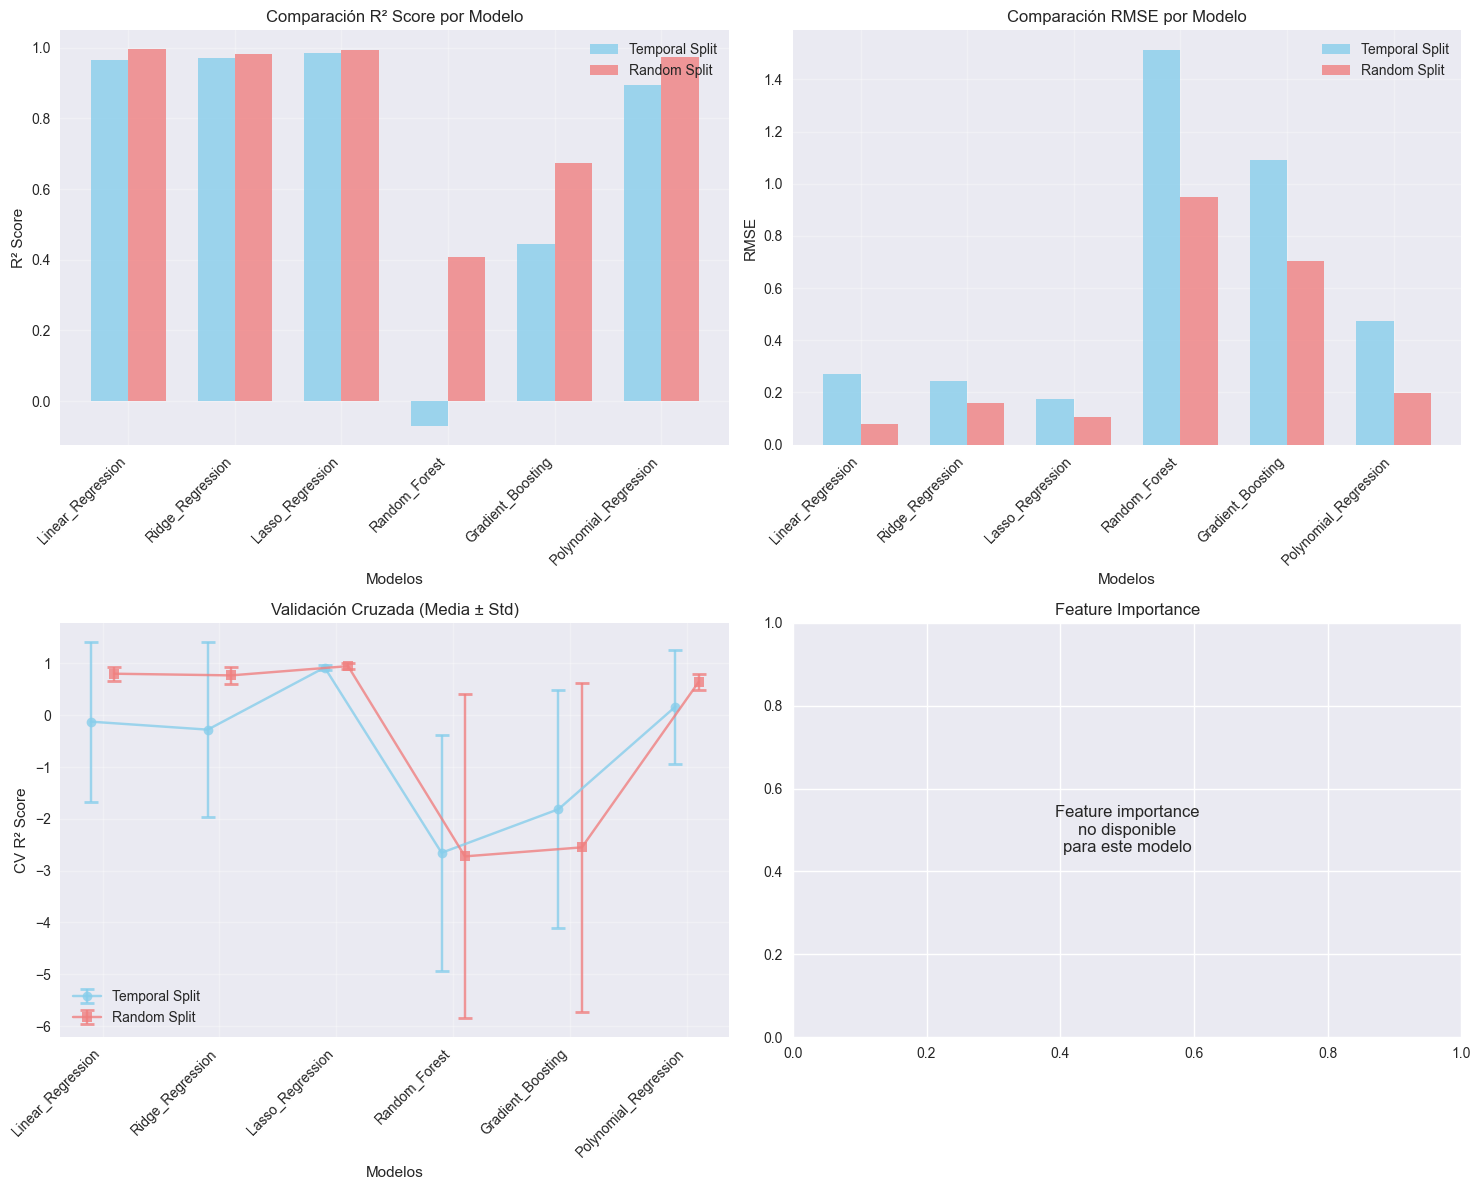

In [28]:
# Crear tabla comparativa de resultados
def create_results_comparison(results_temporal, results_random):
    """
    Crear tabla comparativa de resultados de modelos
    """
    comparison_data = []
    
    # Temporal split results
    for name, metrics in results_temporal.items():
        comparison_data.append({
            'Modelo': name,
            'Split': 'Temporal',
            'R² Train': f"{metrics['train_r2']:.4f}",
            'R² Test': f"{metrics['test_r2']:.4f}",
            'RMSE Test': f"{metrics['test_rmse']:.4f}",
            'MAE Test': f"{metrics['test_mae']:.4f}",
            'CV R² (μ±σ)': f"{metrics['cv_mean']:.4f}±{metrics['cv_std']:.4f}"
        })
    
    # Random split results
    for name, metrics in results_random.items():
        comparison_data.append({
            'Modelo': name,
            'Split': 'Aleatorio',
            'R² Train': f"{metrics['train_r2']:.4f}",
            'R² Test': f"{metrics['test_r2']:.4f}",
            'RMSE Test': f"{metrics['test_rmse']:.4f}",
            'MAE Test': f"{metrics['test_mae']:.4f}",
            'CV R² (μ±σ)': f"{metrics['cv_mean']:.4f}±{metrics['cv_std']:.4f}"
        })
    
    return pd.DataFrame(comparison_data)

# Crear y mostrar tabla comparativa
if 'results_temporal' in locals() and 'results_random' in locals():
    comparison_df = create_results_comparison(results_temporal, results_random)
    
    print("COMPARACIÓN DE MODELOS:")
    print("=" * 100)
    display(comparison_df)
    
    # Encontrar mejores modelos
    best_temporal = max(results_temporal.items(), key=lambda x: x[1]['test_r2'])
    best_random = max(results_random.items(), key=lambda x: x[1]['test_r2'])
    
    print(f"\n🏆 MEJORES MODELOS:")
    print(f"Split Temporal: {best_temporal[0]} (R² = {best_temporal[1]['test_r2']:.4f})")
    print(f"Split Aleatorio: {best_random[0]} (R² = {best_random[1]['test_r2']:.4f})")
    
    # Visualizar comparación de métricas
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # R² Score comparison
    models_names = list(results_temporal.keys())
    r2_temporal = [results_temporal[name]['test_r2'] for name in models_names]
    r2_random = [results_random[name]['test_r2'] for name in models_names]
    
    x = np.arange(len(models_names))
    width = 0.35
    
    axes[0,0].bar(x - width/2, r2_temporal, width, label='Temporal Split', alpha=0.8, color='skyblue')
    axes[0,0].bar(x + width/2, r2_random, width, label='Random Split', alpha=0.8, color='lightcoral')
    axes[0,0].set_xlabel('Modelos')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('Comparación R² Score por Modelo')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(models_names, rotation=45, ha='right')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # RMSE comparison
    rmse_temporal = [results_temporal[name]['test_rmse'] for name in models_names]
    rmse_random = [results_random[name]['test_rmse'] for name in models_names]
    
    axes[0,1].bar(x - width/2, rmse_temporal, width, label='Temporal Split', alpha=0.8, color='skyblue')
    axes[0,1].bar(x + width/2, rmse_random, width, label='Random Split', alpha=0.8, color='lightcoral')
    axes[0,1].set_xlabel('Modelos')
    axes[0,1].set_ylabel('RMSE')
    axes[0,1].set_title('Comparación RMSE por Modelo')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(models_names, rotation=45, ha='right')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Cross-validation scores
    cv_temporal = [results_temporal[name]['cv_mean'] for name in models_names]
    cv_temporal_std = [results_temporal[name]['cv_std'] for name in models_names]
    cv_random = [results_random[name]['cv_mean'] for name in models_names]
    cv_random_std = [results_random[name]['cv_std'] for name in models_names]
    
    axes[1,0].errorbar(x - 0.1, cv_temporal, yerr=cv_temporal_std, fmt='o-', label='Temporal Split', 
                       capsize=5, capthick=2, alpha=0.8, color='skyblue')
    axes[1,0].errorbar(x + 0.1, cv_random, yerr=cv_random_std, fmt='s-', label='Random Split', 
                       capsize=5, capthick=2, alpha=0.8, color='lightcoral')
    axes[1,0].set_xlabel('Modelos')
    axes[1,0].set_ylabel('CV R² Score')
    axes[1,0].set_title('Validación Cruzada (Media ± Std)')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(models_names, rotation=45, ha='right')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Feature importance for best model (if available)
    best_model_name, best_model_results = best_temporal
    best_model = best_model_results['model']
    
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = best_model.feature_importances_
        feature_names = X_train.columns
        
        # Ordenar por importancia
        indices = np.argsort(feature_importance)[::-1]
        
        axes[1,1].bar(range(len(feature_importance)), feature_importance[indices], alpha=0.8, color='green')
        axes[1,1].set_xlabel('Features')
        axes[1,1].set_ylabel('Importancia')
        axes[1,1].set_title(f'Importancia de Features - {best_model_name}')
        axes[1,1].set_xticks(range(len(feature_importance)))
        axes[1,1].set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')
        axes[1,1].grid(True, alpha=0.3)
    else:
        axes[1,1].text(0.5, 0.5, 'Feature importance\nno disponible\npara este modelo', 
                      ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].set_title('Feature Importance')
    
    plt.tight_layout()
    plt.show()
else:    
    print("No hay resultados de modelos para evaluar")

## 9. Predictions and Visualization

Generamos predicciones y creamos visualizaciones comparativas.

Visualizando predicciones del mejor modelo: Lasso_Regression


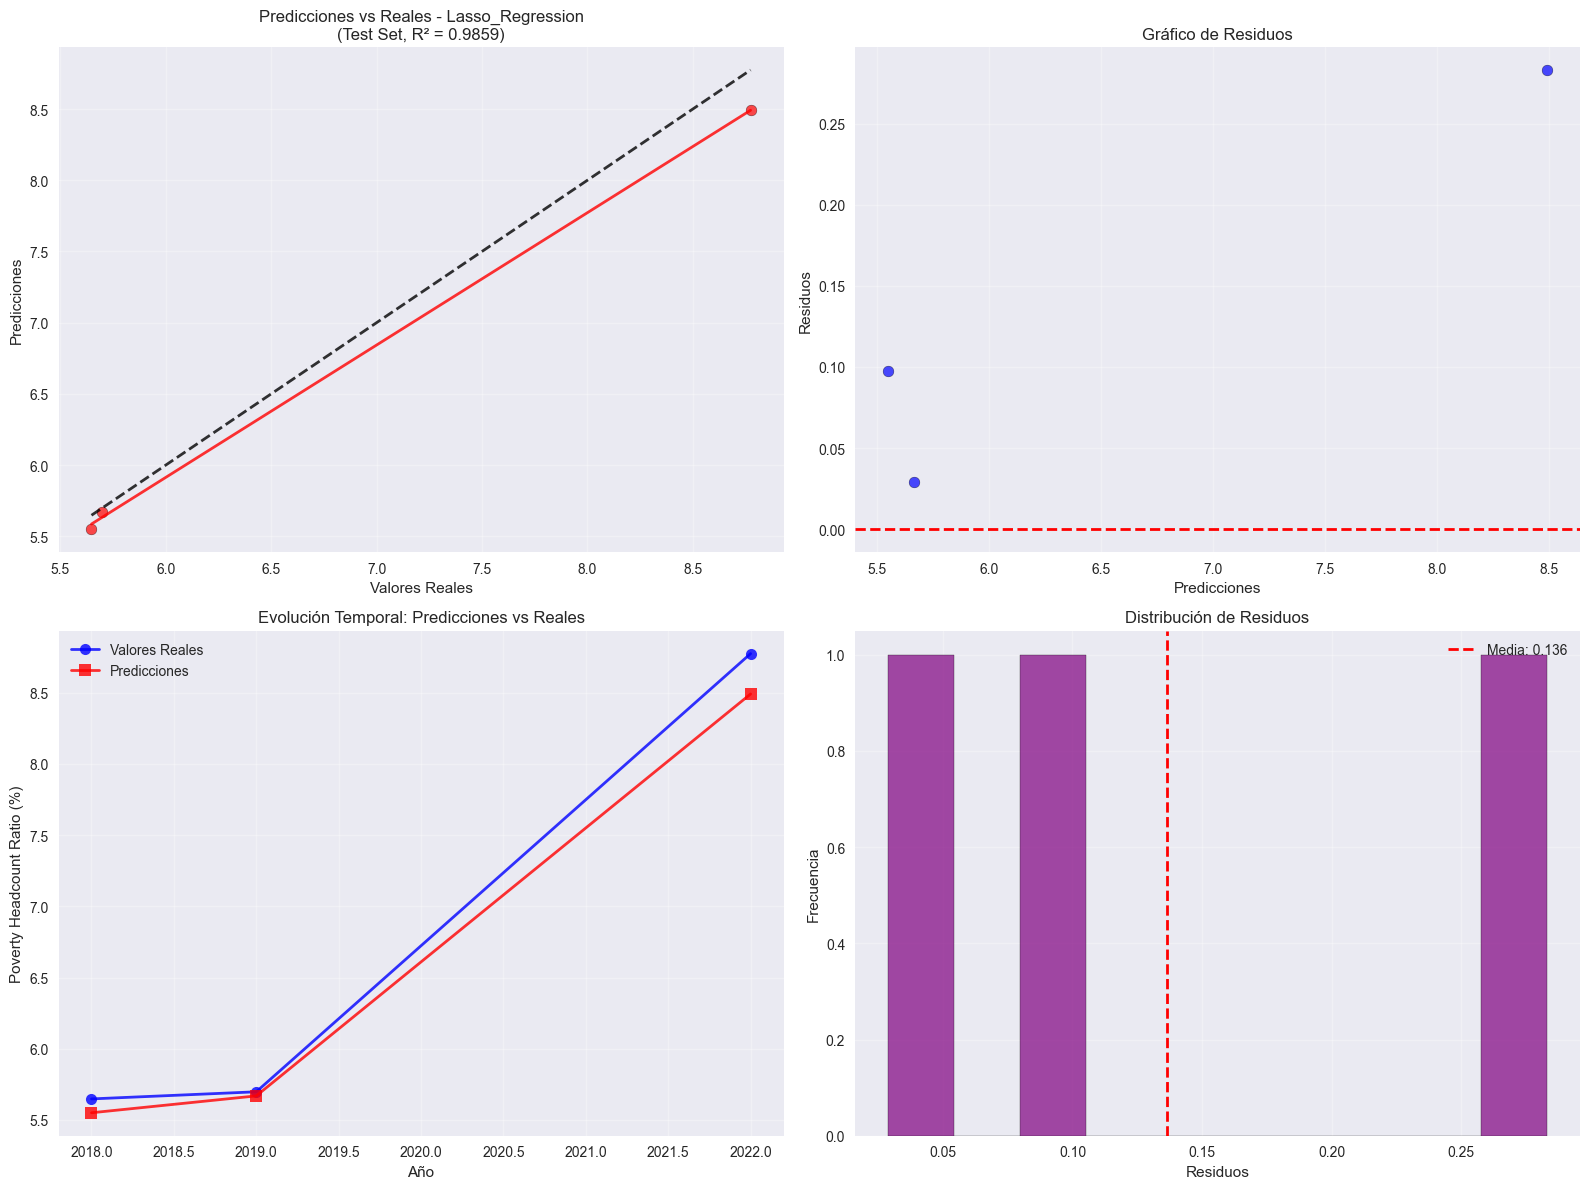

In [29]:
# Visualizaciones de predicciones vs valores reales
if 'results_temporal' in locals() and 'results_random' in locals():
    
    # Obtener mejor modelo
    best_model_name, best_model_results = max(results_temporal.items(), key=lambda x: x[1]['test_r2'])
    
    print(f"Visualizando predicciones del mejor modelo: {best_model_name}")
    
    # Crear visualizaciones
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Predicciones vs Valores Reales (Test Set)
    y_test_pred = best_model_results['y_pred_test']
    
    axes[0,0].scatter(y_test, y_test_pred, alpha=0.7, color='red', s=60, edgecolors='black')
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, alpha=0.8)
    axes[0,0].set_xlabel('Valores Reales')
    axes[0,0].set_ylabel('Predicciones')
    axes[0,0].set_title(f'Predicciones vs Reales - {best_model_name}\n(Test Set, R² = {best_model_results["test_r2"]:.4f})')
    axes[0,0].grid(True, alpha=0.3)
    
    # Añadir línea de regresión
    z = np.polyfit(y_test, y_test_pred, 1)
    p = np.poly1d(z)
    axes[0,0].plot(y_test, p(y_test), "r-", alpha=0.8, linewidth=2)
    
    # 2. Residuos
    residuals = y_test - y_test_pred
    axes[0,1].scatter(y_test_pred, residuals, alpha=0.7, color='blue', s=60, edgecolors='black')
    axes[0,1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0,1].set_xlabel('Predicciones')
    axes[0,1].set_ylabel('Residuos')
    axes[0,1].set_title('Gráfico de Residuos')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Series temporales (si tenemos años)
    if 'years_test' in locals():
        axes[1,0].plot(years_test, y_test, 'o-', label='Valores Reales', 
                       color='blue', linewidth=2, markersize=8, alpha=0.8)
        axes[1,0].plot(years_test, y_test_pred, 's-', label='Predicciones', 
                       color='red', linewidth=2, markersize=8, alpha=0.8)
        axes[1,0].set_xlabel('Año')
        axes[1,0].set_ylabel('Poverty Headcount Ratio (%)')
        axes[1,0].set_title('Evolución Temporal: Predicciones vs Reales')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    else:
        axes[1,0].bar(['Train R²', 'Test R²', 'CV R²'], 
                      [best_model_results['train_r2'], best_model_results['test_r2'], best_model_results['cv_mean']],
                      color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.8, edgecolor='black')
        axes[1,0].set_ylabel('R² Score')
        axes[1,0].set_title('Métricas del Mejor Modelo')
        axes[1,0].grid(True, alpha=0.3)
    
    # 4. Distribución de errores
    axes[1,1].hist(residuals, bins=10, alpha=0.7, color='purple', edgecolor='black')
    axes[1,1].axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, 
                      label=f'Media: {residuals.mean():.3f}')
    axes[1,1].set_xlabel('Residuos')
    axes[1,1].set_ylabel('Frecuencia')
    axes[1,1].set_title('Distribución de Residuos')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Tabla de predicciones detalladas
    predictions_df = pd.DataFrame({
        'Año': years_test if 'years_test' in locals() else range(len(y_test)),
        'Valor_Real': y_test.values,
        'Predicción': y_test_pred,
        'Error_Absoluto': np.abs(residuals),
        'Error_Porcentual': np.abs(residuals) / y_test.values * 100
    })
    
else:
    print("No hay resultados de modelos para visualizar")

## 📈 Predicciones Futuras hasta 2030

Generamos predicciones del Desempleo para Honduras hasta el año 2030 usando el mejor modelo entrenado.

In [32]:
# Generar predicciones futuras de desempleo hasta 2030
def generate_future_unemployment_predictions(best_model_results, model_data_clean, feature_columns, target_years=range(2023, 2031)):
    """
    Genera predicciones futuras de desempleo basadas en el mejor modelo entrenado
    """
    print("🔮 Generando predicciones futuras de desempleo hasta 2030...")
    
    # Obtener el mejor modelo
    best_model = best_model_results['model']
    
    # Obtener los datos históricos para calcular tendencias
    historical_data = model_data_clean.copy()
    last_year = historical_data['Year'].max()
    
    print(f"📊 Año base para proyecciones: {int(last_year)}")
    print(f"📈 Desempleo total en año base: {historical_data['Unemployment_Total'].iloc[-1]:.2f}%")
    
    # Crear dataframe para años futuros
    future_predictions = []
    
    for year in target_years:
        # Crear features para el año futuro basado en patrones históricos
        future_features = {}
        
        # Features temporales
        year_range = historical_data['Year'].max() - historical_data['Year'].min()
        future_features['Year_normalized'] = (year - historical_data['Year'].min()) / year_range if year_range > 0 else 0
        future_features['Year_squared'] = year ** 2
        future_features['Time_trend'] = len(historical_data) + (year - last_year - 1)
        
        # Para features de lag de desempleo, usar la tendencia de los últimos años
        unemployment_lag_features = [col for col in feature_columns if 'lag1' in col and 'Unemployment' in col]
        
        for lag_col in unemployment_lag_features:
            base_col = lag_col.replace('_lag1', '')
            if base_col in historical_data.columns:
                # Calcular tendencia promedio de los últimos 3 años disponibles
                recent_data = historical_data.tail(3)[base_col]
                if len(recent_data) > 1:
                    trend = recent_data.diff().mean()
                    if pd.isna(trend):
                        trend = 0
                    # Proyectar basado en la tendencia
                    last_value = historical_data[base_col].iloc[-1]
                    future_features[lag_col] = last_value + trend * (year - last_year - 1)
                else:
                    future_features[lag_col] = historical_data[base_col].iloc[-1]
        
        # Proyectar variables de género basadas en tendencias históricas
        if 'Unemployment_Female' in historical_data.columns and 'Unemployment_Male' in historical_data.columns:
            # Calcular tendencias de género
            female_trend = historical_data['Unemployment_Female'].diff().tail(3).mean()
            male_trend = historical_data['Unemployment_Male'].diff().tail(3).mean()
            
            if pd.isna(female_trend): female_trend = 0
            if pd.isna(male_trend): male_trend = 0
            
            years_ahead = year - last_year
            projected_female = historical_data['Unemployment_Female'].iloc[-1] + female_trend * years_ahead
            projected_male = historical_data['Unemployment_Male'].iloc[-1] + male_trend * years_ahead
            
            # Recalcular variables derivadas de género
            if 'Gender_Gap' in feature_columns:
                future_features['Gender_Gap'] = projected_female - projected_male
            if 'Gender_Ratio' in feature_columns:
                future_features['Gender_Ratio'] = projected_female / (projected_male + 0.001)
            if 'Gender_Average' in feature_columns:
                future_features['Gender_Average'] = (projected_female + projected_male) / 2
        
        # Proyectar variables de educación basadas en tendencias históricas
        if 'Unemployment_Basic_Education' in historical_data.columns and 'Unemployment_Advanced_Education' in historical_data.columns:
            basic_trend = historical_data['Unemployment_Basic_Education'].diff().tail(3).mean()
            advanced_trend = historical_data['Unemployment_Advanced_Education'].diff().tail(3).mean()
            
            if pd.isna(basic_trend): basic_trend = 0
            if pd.isna(advanced_trend): advanced_trend = 0
            
            years_ahead = year - last_year
            projected_basic = historical_data['Unemployment_Basic_Education'].iloc[-1] + basic_trend * years_ahead
            projected_advanced = historical_data['Unemployment_Advanced_Education'].iloc[-1] + advanced_trend * years_ahead
            
            # Recalcular variables derivadas de educación
            if 'Education_Gap' in feature_columns:
                future_features['Education_Gap'] = projected_basic - projected_advanced
            if 'Education_Ratio' in feature_columns:
                future_features['Education_Ratio'] = projected_basic / (projected_advanced + 0.001)
            if 'Education_Average' in feature_columns:
                future_features['Education_Average'] = (projected_basic + projected_advanced) / 2
        
        # Para features de cambio porcentual, usar promedio histórico
        for col in feature_columns:
            if col.endswith('_change') and col not in future_features:
                if col in historical_data.columns:
                    avg_change = historical_data[col].mean()
                    if pd.isna(avg_change):
                        avg_change = 0
                    future_features[col] = avg_change
        
        # Asegurar que todas las features necesarias estén presentes
        feature_vector = []
        for col in feature_columns:
            if col in future_features:
                feature_vector.append(future_features[col])
            else:
                # Para features faltantes, usar promedio histórico o 0
                if col in historical_data.columns:
                    avg_val = historical_data[col].mean()
                    feature_vector.append(avg_val if not pd.isna(avg_val) else 0)
                else:
                    feature_vector.append(0)
        
        # Crear DataFrame para predicción
        X_future = pd.DataFrame([feature_vector], columns=feature_columns)
        
        # Generar predicción
        try:
            prediction = best_model.predict(X_future)[0]
            
            # Asegurar que la predicción sea realista para desempleo (entre 0% y 50%)
            prediction = max(0, min(prediction, 50))
            
            future_predictions.append({
                'Year': year,
                'Predicted_Unemployment_Rate': prediction
            })
            
        except Exception as e:
            print(f"⚠️ Error prediciendo {year}: {e}")
            # Usar extrapolación simple como fallback
            if future_predictions:
                last_pred = future_predictions[-1]['Predicted_Unemployment_Rate']
                future_predictions.append({
                    'Year': year,
                    'Predicted_Unemployment_Rate': last_pred
                })
            else:
                future_predictions.append({
                    'Year': year,
                    'Predicted_Unemployment_Rate': historical_data['Unemployment_Total'].iloc[-1]
                })
    
    return pd.DataFrame(future_predictions)

# Generar predicciones si tenemos el mejor modelo
if 'best_model_results' in locals() and 'model_data_clean' in locals():
    future_df = generate_future_unemployment_predictions(best_model_results, model_data_clean, feature_columns)
    
    print(f"\n🎯 PREDICCIONES FUTURAS DE DESEMPLEO GENERADAS:")
    print("=" * 60)
    for _, row in future_df.iterrows():
        print(f"   {int(row['Year'])}: {row['Predicted_Unemployment_Rate']:.2f}%")
    
    # Combinar datos históricos y predicciones para visualización
    historical_summary = model_data_clean[['Year', 'Unemployment_Total']].copy()
    historical_summary = historical_summary.rename(columns={'Unemployment_Total': 'Historical_Unemployment_Rate'})
    
    # Crear dataset completo
    complete_timeline = pd.merge(
        historical_summary, 
        future_df.rename(columns={'Predicted_Unemployment_Rate': 'Future_Unemployment_Rate'}), 
        on='Year', 
        how='outer'
    ).sort_values('Year')
    
    print(f"\n📊 RESUMEN COMPLETO DESEMPLEO EN HONDURAS (2010-2030):")
    print("=" * 60)
    display(complete_timeline.round(2))
    
    # Análisis de tendencias
    future_trend = (future_df['Predicted_Unemployment_Rate'].iloc[-1] - future_df['Predicted_Unemployment_Rate'].iloc[0]) / len(future_df)
    trend_direction = "📈 CRECIENTE" if future_trend > 0 else "📉 DECRECIENTE" if future_trend < 0 else "📊 ESTABLE"
    
    print(f"\n🔍 ANÁLISIS DE TENDENCIAS:")
    print(f"   {trend_direction} ({future_trend:.3f}% por año)")
    print(f"   🎯 Desempleo promedio proyectado (2023-2030): {future_df['Predicted_Unemployment_Rate'].mean():.2f}%")
    print(f"   📊 Rango proyectado: {future_df['Predicted_Unemployment_Rate'].min():.2f}% - {future_df['Predicted_Unemployment_Rate'].max():.2f}%")
    
else:
    print("❌ No se pueden generar predicciones - falta el modelo entrenado o datos")

🔮 Generando predicciones futuras de desempleo hasta 2030...
📊 Año base para proyecciones: 2022
📈 Desempleo total en año base: 8.77%

🎯 PREDICCIONES FUTURAS DE DESEMPLEO GENERADAS:
   2023: 9.12%
   2024: 9.98%
   2025: 10.83%
   2026: 11.69%
   2027: 12.55%
   2028: 13.40%
   2029: 14.26%
   2030: 15.12%

📊 RESUMEN COMPLETO DESEMPLEO EN HONDURAS (2010-2030):


,Year,Historical_Unemployment_Rate,Future_Unemployment_Rate
0,2011,4.47,NaN
1,2012,3.76,NaN
2,2013,5.65,NaN
3,2014,7.08,NaN
4,2015,6.15,NaN
5,2016,6.73,NaN
6,2017,5.53,NaN
7,2018,5.65,NaN
8,2019,5.70,NaN
9,2022,8.77,NaN



🔍 ANÁLISIS DE TENDENCIAS:
   📈 CRECIENTE (0.750% por año)
   🎯 Desempleo promedio proyectado (2023-2030): 12.12%
   📊 Rango proyectado: 9.12% - 15.12%


📈 Creando visualizaciones de predicciones futuras de desempleo...


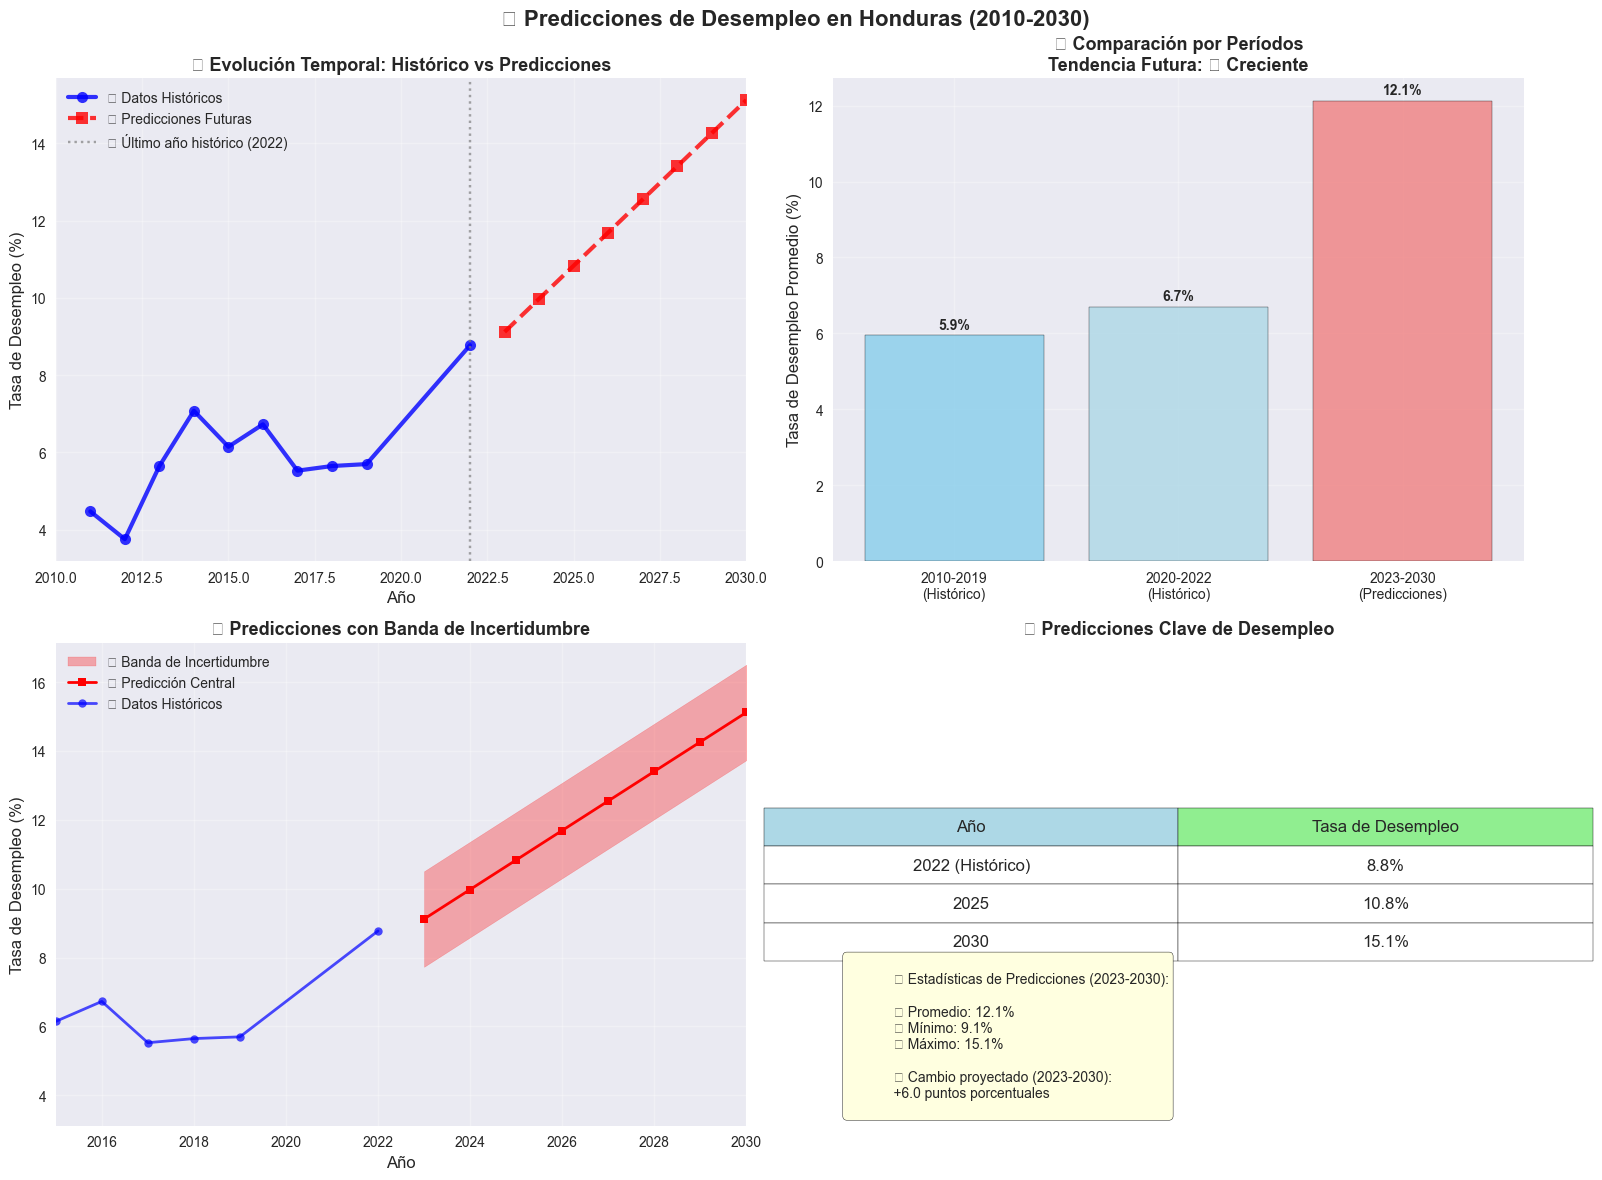


📋 RESUMEN ESTADÍSTICO DE PREDICCIONES:
🎯 Modelo utilizado: Lasso_Regression
📅 Período de predicción: 2023-2030
📊 Desempleo máximo proyectado: 15.12% (año 2030)
📉 Desempleo mínimo proyectado: 9.12% (año 2023)
🎯 Promedio 2023-2030: 12.12%
📊 Desviación estándar: 2.10%

🔄 COMPARACIÓN CON DATOS HISTÓRICOS:
   📊 Último dato histórico (2022): 8.77%
   🔮 Promedio futuro proyectado: 12.12%
   📈 INCREMENTO: 3.34 puntos porcentuales


In [34]:
# Visualización de predicciones futuras de desempleo
if 'future_df' in locals() and 'complete_timeline' in locals():
    
    print("📈 Creando visualizaciones de predicciones futuras de desempleo...")
    
    # Crear visualización completa
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🔮 Predicciones de Desempleo en Honduras (2010-2030)', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # 1. Serie temporal completa (histórico + predicciones)
    historical_years = complete_timeline.dropna(subset=['Historical_Unemployment_Rate'])['Year']
    historical_values = complete_timeline.dropna(subset=['Historical_Unemployment_Rate'])['Historical_Unemployment_Rate']
    
    future_years = complete_timeline.dropna(subset=['Future_Unemployment_Rate'])['Year']
    future_values = complete_timeline.dropna(subset=['Future_Unemployment_Rate'])['Future_Unemployment_Rate']
    
    # Gráfico principal
    axes[0,0].plot(historical_years, historical_values, 'o-', linewidth=3, markersize=8, 
                   color='blue', label='📊 Datos Históricos', alpha=0.8)
    axes[0,0].plot(future_years, future_values, 's--', linewidth=3, markersize=8, 
                   color='red', label='🔮 Predicciones Futuras', alpha=0.8)
    
    # Línea vertical separando histórico de predicciones
    if len(historical_years) > 0:
        last_historical_year = historical_years.max()
        axes[0,0].axvline(x=last_historical_year, color='gray', linestyle=':', alpha=0.7, 
                          label=f'📅 Último año histórico ({int(last_historical_year)})')
    
    axes[0,0].set_xlabel('Año', fontsize=12)
    axes[0,0].set_ylabel('Tasa de Desempleo (%)', fontsize=12)
    axes[0,0].set_title('📈 Evolución Temporal: Histórico vs Predicciones', fontsize=13, fontweight='bold')
    axes[0,0].legend(fontsize=10)
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_xlim(2010, 2030)
    
    # 2. Análisis de tendencia
    if len(future_values) > 1:
        # Calcular tendencia futura
        future_trend = np.polyfit(range(len(future_values)), future_values, 1)[0]
        trend_direction = "📈 Creciente" if future_trend > 0 else "📉 Decreciente" if future_trend < 0 else "📊 Estable"
        
        periods_data = []
        periods_labels = []
        
        if len(historical_values) > 0:
            periods_data.append(historical_values.mean())
            periods_labels.append('2010-2019\n(Histórico)')
            
            if len(historical_values) >= 3:
                periods_data.append(historical_values.tail(3).mean())
                periods_labels.append('2020-2022\n(Histórico)')
        
        periods_data.append(future_values.mean())
        periods_labels.append('2023-2030\n(Predicciones)')
        
        bars = axes[0,1].bar(periods_labels, periods_data,
                            color=['skyblue', 'lightblue', 'lightcoral'][:len(periods_data)], 
                            alpha=0.8, edgecolor='black')
        
        axes[0,1].set_ylabel('Tasa de Desempleo Promedio (%)', fontsize=12)
        axes[0,1].set_title(f'📊 Comparación por Períodos\nTendencia Futura: {trend_direction}', 
                            fontsize=13, fontweight='bold')
        axes[0,1].grid(True, alpha=0.3)
        
        # Añadir valores en las barras
        for bar, value in zip(bars, periods_data):
            axes[0,1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1, 
                          f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 3. Rango de incertidumbre (estimación simple)
    if len(historical_values) > 1:
        historical_std = historical_values.std()
        
        # Crear bandas de confianza para predicciones
        upper_bound = future_values + historical_std
        lower_bound = future_values - historical_std
        
        axes[1,0].fill_between(future_years, lower_bound, upper_bound, 
                               alpha=0.3, color='red', label='🔍 Banda de Incertidumbre')
        axes[1,0].plot(future_years, future_values, 'r-', linewidth=2, 
                       label='🎯 Predicción Central', marker='s', markersize=6)
        
        if len(historical_values) > 0:
            axes[1,0].plot(historical_years, historical_values, 'b-', linewidth=2, 
                           label='📊 Datos Históricos', marker='o', markersize=6, alpha=0.7)
        
        axes[1,0].set_xlabel('Año', fontsize=12)
        axes[1,0].set_ylabel('Tasa de Desempleo (%)', fontsize=12)
        axes[1,0].set_title('🔮 Predicciones con Banda de Incertidumbre', fontsize=13, fontweight='bold')
        axes[1,0].legend(fontsize=10)
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].set_xlim(2015, 2030)
    
    # 4. Tabla resumen de predicciones clave
    key_years = [2025, 2030]
    key_predictions = future_df[future_df['Year'].isin(key_years)]
    
    if not key_predictions.empty:
        # Crear tabla visual
        table_data = []
        for _, row in key_predictions.iterrows():
            table_data.append([f"{int(row['Year'])}", f"{row['Predicted_Unemployment_Rate']:.1f}%"])
        
        # Añadir datos históricos clave para comparación
        if len(historical_values) > 0:
            last_historical_year = int(historical_years.iloc[-1])
            table_data.insert(0, [f"{last_historical_year} (Histórico)", f"{historical_values.iloc[-1]:.1f}%"])
        
        # Crear tabla
        table = axes[1,1].table(cellText=table_data,
                                colLabels=['Año', 'Tasa de Desempleo'],
                                cellLoc='center',
                                loc='center',
                                colColours=['lightblue', 'lightgreen'])
        
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 2)
        
        axes[1,1].axis('off')
        axes[1,1].set_title('🎯 Predicciones Clave de Desempleo', fontsize=13, fontweight='bold')
        
        # Añadir estadísticas adicionales
        if len(future_values) > 0:
            stats_text = f"""
            📊 Estadísticas de Predicciones (2023-2030):
            
            📈 Promedio: {future_values.mean():.1f}%
            📉 Mínimo: {future_values.min():.1f}%
            📊 Máximo: {future_values.max():.1f}%
            
            🔄 Cambio proyectado (2023-2030):
            {future_values.iloc[-1] - future_values.iloc[0]:+.1f} puntos porcentuales
            """
            
            axes[1,1].text(0.02, 0.02, stats_text, transform=axes[1,1].transAxes,
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"),
                           fontsize=10, verticalalignment='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Resumen estadístico adicional
    print(f"\n📋 RESUMEN ESTADÍSTICO DE PREDICCIONES:")
    print("=" * 55)
    print(f"🎯 Modelo utilizado: {best_model_name if 'best_model_name' in locals() else 'Mejor modelo disponible'}")
    print(f"📅 Período de predicción: 2023-2030")
    print(f"📊 Desempleo máximo proyectado: {future_df['Predicted_Unemployment_Rate'].max():.2f}% (año {future_df.loc[future_df['Predicted_Unemployment_Rate'].idxmax(), 'Year']:.0f})")
    print(f"📉 Desempleo mínimo proyectado: {future_df['Predicted_Unemployment_Rate'].min():.2f}% (año {future_df.loc[future_df['Predicted_Unemployment_Rate'].idxmin(), 'Year']:.0f})")
    print(f"🎯 Promedio 2023-2030: {future_df['Predicted_Unemployment_Rate'].mean():.2f}%")
    print(f"📊 Desviación estándar: {future_df['Predicted_Unemployment_Rate'].std():.2f}%")
    
    # Comparación con últimos datos históricos
    if len(historical_values) > 0:
        last_historical = historical_values.iloc[-1]
        avg_future = future_df['Predicted_Unemployment_Rate'].mean()
        change = avg_future - last_historical
        change_direction = "📈 INCREMENTO" if change > 0 else "📉 REDUCCIÓN" if change < 0 else "📊 ESTABILIDAD"
        
        print(f"\n🔄 COMPARACIÓN CON DATOS HISTÓRICOS:")
        print(f"   📊 Último dato histórico ({int(historical_years.iloc[-1])}): {last_historical:.2f}%")
        print(f"   🔮 Promedio futuro proyectado: {avg_future:.2f}%")
        print(f"   {change_direction}: {abs(change):.2f} puntos porcentuales")
    
else:
    print("❌ No se pueden crear visualizaciones - faltan datos de predicciones")